In [13]:
import jax
num_devices = jax.local_device_count()
print(f'# of GPUs : {num_devices}')

import haiku as hk
import optax
import numpy as np
import jax.numpy as jnp
from tqdm import tqdm
from functools import partial
from itertools import product

# we import some helper function/classes
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import *
from models.resnet import ResNet, Block
from datasets.cifar import load_dataset

import matplotlib.pyplot as plt

# of GPUs : 8


# Simple landscape visualization

(30, 30) (30, 30)
(30, 30)


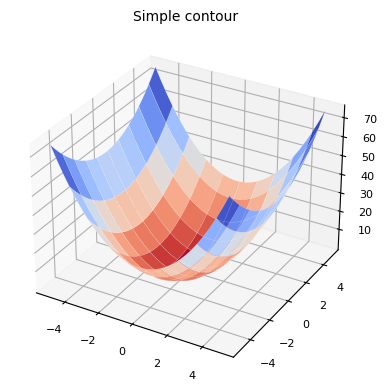

In [14]:
x = np.linspace(-5, 5, 30)
y = np.linspace(-5, 5, 30)
xv, yv = np.meshgrid(x, y)
print(xv.shape, yv.shape)

f = lambda x, y: 2 * x**2 + y**2
z = f(xv, yv)
print(z.shape)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(xv, yv, z, cmap='coolwarm_r', rstride=3, cstride=3)
ax.plot_wireframe(xv, yv, z, color='white', linewidth=0.1, rstride=3, cstride=3)
ax.set_title('Simple contour', fontsize=10)
plt.tight_layout()
plt.show()

# Reload pre-trained NN

In [15]:
NUM_CLASSES = 100
NUM_EPOCH = 200
NUM_TRAIN = 50000
BATCH_SIZE = 1000
WARMUP_RATIO = 0.1
PEAK_LR = 0.4

rng = jax.random.PRNGKey(42)
batch = jnp.zeros((1, 32, 32, 3), jnp.float32)
net = partial(
    ResNet,
    name='ResNet_18',
    stage_sizes=[2, 2, 2, 2],
    num_filters=[64, 128, 256, 512],
    strides=[1, 2, 2, 2],
    block_cls=Block,
    num_classes=NUM_CLASSES,
)

net = make_forward_with_state(net)
params, state = net.init(rng, batch, train=True, print_shape=True)

tx = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.sgd(learning_rate=create_lr_sched(NUM_EPOCH, NUM_TRAIN, BATCH_SIZE, WARMUP_RATIO, PEAK_LR), momentum=0.9)
    )
trainer = Trainer.create(
    apply_fn=net.apply,
    params=params,
    state=state,
    tx=tx,
)

input : (1, 32, 32, 3)
embedding : (1, 32, 32, 64)
block_0_0 : (1, 32, 32, 64)
block_0_1 : (1, 32, 32, 64)
block_1_0 : (1, 16, 16, 128)
block_1_1 : (1, 16, 16, 128)
block_2_0 : (1, 8, 8, 256)
block_2_1 : (1, 8, 8, 256)
block_3_0 : (1, 4, 4, 512)
block_3_1 : (1, 4, 4, 512)
representation : (1, 512)
classifier head : (1, 100)


In [16]:
trainer = load_ckpt('../3_image_classification/result/cifar100/renset_18', trainer)

batch_dims = (num_devices, BATCH_SIZE//num_devices)
train_dataset = list(load_dataset(NUM_CLASSES, batch_dims, True, False, False))
test_dataset = list(load_dataset(NUM_CLASSES, batch_dims, False, False, False))

test_acc = compute_acc_dataset(replicate(trainer), test_dataset)
print(f'Recovered Test Accuracy : {test_acc:.4f}')

KeyboardInterrupt: 

In [ ]:
x = np.linspace(-1, 1, 10)
y = np.linspace(-1, 1, 10)
xv, yv = np.meshgrid(x, y)
print(xv.shape, yv.shape)

(10, 10) (10, 10)


In [ ]:
# sample random direction
vec_params, unravel_fn = params_to_vec(trainer.params, True)
rng, rng_x, rng_y = jax.random.split(rng, 3)
x_vec = jax.random.normal(rng_x, vec_params.shape)
y_vec = jax.random.normal(rng_y, vec_params.shape)

z = np.zeros_like(xv)
for i,j in tqdm(list(product(range(10), repeat=2))):
    # define perturbation
    alpha, beta = x[i], y[j]
    pert = alpha * x_vec + beta * y_vec
    perturbed_params = vec_params + pert
    perturbed_trainer = trainer.replace(params=unravel_fn(perturbed_params))
    acc_te = compute_loss_dataset(replicate(perturbed_trainer), train_dataset)
    z[i][j] = acc_te

100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


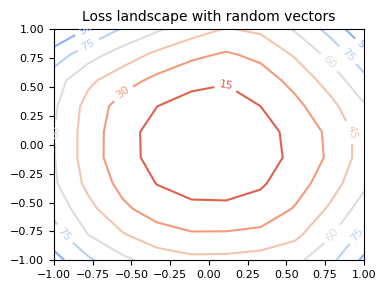

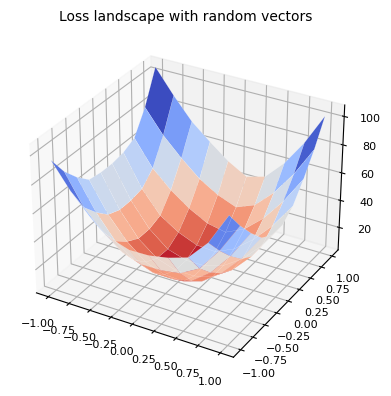

In [ ]:
contour = plt.contour(xv, yv, z, cmap='coolwarm_r')
plt.clabel(contour, inline=True, fontsize=8)
plt.title(f'Loss landscape with random vectors', fontsize=10)
plt.show()

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(xv, yv, z, cmap='coolwarm_r', rstride=1, cstride=1)
ax.plot_wireframe(xv, yv, z, color='white', linewidth=0.1, rstride=1, cstride=1)
ax.set_title(f'Loss landscape with random vectors', fontsize=10)
plt.tight_layout()
plt.show()

# Filter Normalized loss landscape

In [ ]:
x = np.linspace(-1, 1, 10)
y = np.linspace(-1, 1, 10)
xv, yv = np.meshgrid(x, y)
print(xv.shape, yv.shape)

(10, 10) (10, 10)


In [ ]:
def filter_normalize_module(module_name, name, value):
    # filter normalization for Conv & FC layers
    if (name=='w') and (len(value.shape)==4):
        scale = 1./jnp.sqrt(jnp.sum(value**2, axis=(0,1,2), keepdims=True))
    elif (name=='w') and (len(value.shape)==2):
        scale = 1./jnp.sqrt(jnp.sum(value**2, axis=0, keepdims=True))
    else:
        # mask bias & params of normalization layers
        scale = 0.
    value = value * scale
    return value

def scale_pert(pert, param):
    if len(pert.shape)==4:
        scale = jnp.sqrt(jnp.sum(param**2, axis=(0,1,2), keepdims=True))
    elif len(pert.shape)==2:
        scale = jnp.sqrt(jnp.sum(param**2, axis=0, keepdims=True))
    else:
        scale = 0.
    pert = pert * scale
    return pert

def filter_normalize_pert(pert, params):
    pert = hk.data_structures.map(filter_normalize_module, pert)
    pert = jax.tree_util.tree_map(scale_pert, pert, params)
    return pert

In [ ]:
# sample random direction
vec_params, unravel_fn = params_to_vec(trainer.params, True)
rng, rng_x, rng_y = jax.random.split(rng, 3)
x_vec = jax.random.normal(rng_x, vec_params.shape)
y_vec = jax.random.normal(rng_y, vec_params.shape)

# normalize random vector
x_vec = params_to_vec(filter_normalize_pert(unravel_fn(x_vec), trainer.params))
y_vec = params_to_vec(filter_normalize_pert(unravel_fn(y_vec), trainer.params))

z = np.zeros_like(xv)
for i,j in tqdm(list(product(range(10), repeat=2))):
        # define perturbation
        alpha, beta = x[i], y[j]
        pert = alpha * x_vec + beta * y_vec
        perturbed_params = vec_params + pert
        perturbed_trainer = trainer.replace(params=unravel_fn(perturbed_params))
        acc_te = compute_loss_dataset(replicate(perturbed_trainer), train_dataset)
        z[i][j] = acc_te

100%|██████████| 100/100 [01:51<00:00,  1.12s/it]


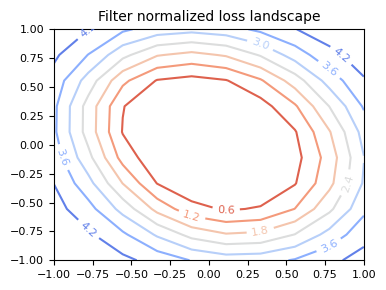

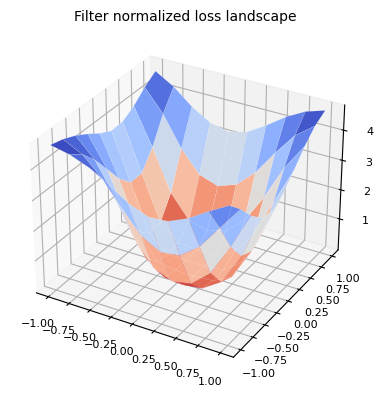

In [ ]:
contour = plt.contour(xv, yv, z, cmap='coolwarm_r')
plt.clabel(contour, inline=True, fontsize=8)
plt.title(f'Filter normalized loss landscape', fontsize=10)
plt.show()

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(xv, yv, z, cmap='coolwarm_r', rstride=1, cstride=1)
ax.plot_wireframe(xv, yv, z, color='white', linewidth=0.1, rstride=1, cstride=1)
ax.set_title(f'Filter normalized loss landscape', fontsize=10)
plt.tight_layout()
plt.show()